In [123]:
import pandas as pd
import csv
import ast

In [124]:
path = r"C:\Users\joacosta\Work\Beumer\MTN6\Extracted\Logmonitor\19_Nov\S02_Log_From_11192025_0845_To_11192025_0850.csv"

In [125]:
raw_df = pd.read_csv(
    path,
    sep=";",
    header=None,
    engine="python",
    quoting=csv.QUOTE_NONE,
    skipinitialspace=True,
    on_bad_lines="skip",
    dtype=str
)

In [126]:
raw_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11
0,"""251119 084500 074""","""N""","""SMC""","""10.121.112.14:7200""","""AWCS.Comm""","""""","""""","""09:44:55,093",MC01,54163,SQ 154,"->{event: ""AwcsConverterReceiveS02"", awcsActio..."


In [127]:
df_no_quotation = raw_df.replace('"', '', regex=True)
# Rename original df columns
df_no_quotation.columns = [
    "timeStamp", "flag", "systemName", "ipAddress", "sender", "unkown",
    "unkown_2", "PLCTimeStamp", "machineCode", "unitID", "sequenceNo",
    "rawMessage"
]

df_no_quotation["rawMessage"] = df_no_quotation["rawMessage"].str.removeprefix("->{").str.removesuffix("}<")

def split_key_values(text):
    parts = []
    buf = ""
    inside_brackets = 0
    
    for ch in text:
        if ch == "[":
            inside_brackets += 1
        elif ch == "]":
            inside_brackets -= 1
        
        if ch == "," and inside_brackets == 0:
            parts.append(buf.strip())
            buf = ""
        else:
            buf += ch
    if buf:
        parts.append(buf.strip())
    return parts

def parse_row(text):
    items = split_key_values(text)
    d = {}
    for item in items:
        if ":" in item:
            k, v = item.split(":", 1)
            d[k.strip()] = v.strip()
    return d

df_expanded = df_no_quotation["rawMessage"].apply(parse_row).apply(pd.Series)

# Function to parse array-like strings and return the first element
def first_element(val):
    if isinstance(val, str) and val.startswith("[") and val.endswith("]"):
        try:
            # Try to parse safely into Python list
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list) and parsed:
                return parsed[0]
        except (ValueError, SyntaxError):
            # If literal_eval fails (e.g. strings without quotes like [Used,FromAwcs])
            parts = [x.strip() for x in val.strip("[]").split(",")]
            return parts[0] if parts else val
    return val

# Apply to your target columns
for col in ["requestedDestMCID", "sortCode", "requestedDestStatus"]:
    df_expanded[col] = df_expanded[col].apply(first_element)

# Drop the old structured column
df_temp = df_no_quotation.drop(columns=["rawMessage"])

# Merge with expanded dataframe
df_clean = pd.concat([df_temp, df_expanded], axis=1)

df_clean.head(10)

,timeStamp,flag,systemName,ipAddress,sender,unkown,unkown_2,PLCTimeStamp,machineCode,unitID,...,itemID,indexNo,locationID,barcodeAWCS,requestedDestMCID,sortCode,requestedDestStatus,comHost,comMode,telegramType
0,251119 084500 074,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,093",MC01,54163,...,157381U,1687,S01ah,SBxktpLFF8_001_v,189,-1,Used,AwcsConverterAwcsIf,Receive,S02
1,251119 084500 213,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,224",MC01,54163,...,156892U,1196,S01aa,SBxjqfrGNg_001_v,215,-1,Used,AwcsConverterAwcsIf,Receive,S02
2,251119 084500 330,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,343",MC01,54163,...,157498U,1806,S01ac,SBBm8Dsc9g_001_v,342,-1,Used,AwcsConverterAwcsIf,Receive,S02
3,251119 084500 430,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,432",MC01,54163,...,157379U,1685,S01ag,SBB6VXFL1g_001_v,119,-1,Used,AwcsConverterAwcsIf,Receive,S02
4,251119 084500 448,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,447",MC01,54163,...,157406U,1713,S01ae,SBWkRlCY5g_001_v,3005,-1,Used,AwcsConverterAwcsIf,Receive,S02
5,251119 084500 535,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,553",MC01,54163,...,157313U,1619,S01ab,SBh0D5rlPg_001_v,248,-1,Used,AwcsConverterAwcsIf,Receive,S02
6,251119 084500 643,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,662",MC01,54163,...,157371U,1677,S01af,SBBj67zf4g_001_v,29,-1,Used,AwcsConverterAwcsIf,Receive,S02
7,251119 084500 661,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,675",MC01,54163,...,157497U,1805,S01ae,SBsQWHHv08_001_v,3005,-1,Used,AwcsConverterAwcsIf,Receive,S02
8,251119 084500 685,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,692",MC01,54163,...,157329U,1635,S01ad,SP5P9PpRDV_001_v,437,-1,Used,AwcsConverterAwcsIf,Receive,S02
9,251119 084500 743,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,763",MC01,54163,...,156049U,0346,S01af,SBt0q92gtX_001_v,29,-1,Used,AwcsConverterAwcsIf,Receive,S02


In [128]:
def load_mapping() -> dict:
    """
    Load and clean the destination mapping file for the specified site.

    The file name must follow the convention: "<SITE>_Destination_Mapping.xlsx".
    """
    # Construct file path based on site name
    mapping_path = r"C:\Users\joacosta\Work\Beumer\MTN6\Python\Amazon_MTN6_Analytics\data\MTN6_Destination_Mapping.xlsx"

    print("\nExtracting Mapping Destination Names for MTN6...")


    # Load Excel file
    df = pd.read_excel(mapping_path, dtype=str)

    # Clean strings: remove spaces and quotes if present
    for col in df.columns:
        df[col] = df[col].apply(lambda x: str(x).strip() if pd.notnull(x) else x)

    # Build mapping: IndexNo -> {'amazon': ..., 'beumer': ..., 'jackpot': ...}
    mapping = {
        int(row["IndexNo"]): {
            "amazon": row["Amazon"],
            "beumer": row["Beumer"],
            "jackpot": row["Jackpot"],
        }
        for _, row in df.iterrows()
    }

    # Add recirculation mapping for 3000-3999 range
    for index in range(3000, 4000):
        if index not in mapping:
            mapping[index] = {
                "amazon": "Recirculation",
                "beumer": "Recirculation",
                "jackpot": None,  # or specify a value if needed
            }
        else:
            # Override existing mappings in this range
            mapping[index]["amazon"] = "Recirculation"
            mapping[index]["beumer"] = "Recirculation"

    print("Mapping file for MTN6 loaded successfully.")
    return mapping

In [129]:
def enrich_window_df(window_df: pd.DataFrame, mapping: dict) -> pd.DataFrame:
    """Apply all enrichment mappings to window_df."""

    map_series = window_df["requestedDestMCID"].map(mapping)
    # Expand mapping into separate columns
    window_df["Amazon_Destination"] = map_series.apply(
        lambda x: x["amazon"] if isinstance(x, dict) else None
    )
    window_df["Beumer_Destination"] = map_series.apply(
        lambda x: x["beumer"] if isinstance(x, dict) else None
    )
    window_df["Jackpot_Destination"] = map_series.apply(
        lambda x: x["jackpot"] if isinstance(x, dict) else None
    )

    return window_df

In [130]:
mapping_destination_names = load_mapping()
window_df = enrich_window_df(df_clean, mapping_destination_names)
window_df.head(30)


Extracting Mapping Destination Names for MTN6...
Mapping file for MTN6 loaded successfully.


,timeStamp,flag,systemName,ipAddress,sender,unkown,unkown_2,PLCTimeStamp,machineCode,unitID,...,barcodeAWCS,requestedDestMCID,sortCode,requestedDestStatus,comHost,comMode,telegramType,Amazon_Destination,Beumer_Destination,Jackpot_Destination
0,251119 084500 074,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,093",MC01,54163,...,SBxktpLFF8_001_v,189,-1,Used,AwcsConverterAwcsIf,Receive,S02,S014065,CHU260,NaN
1,251119 084500 213,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,224",MC01,54163,...,SBxjqfrGNg_001_v,215,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01aa-S01ad,CHU721,NaN
2,251119 084500 330,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,343",MC01,54163,...,SBBm8Dsc9g_001_v,342,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ac-S01ab,CHU705,NaN
3,251119 084500 430,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,432",MC01,54163,...,SBB6VXFL1g_001_v,119,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ag-S01af,CHU735,NaN
4,251119 084500 448,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,447",MC01,54163,...,SBWkRlCY5g_001_v,3005,-1,Used,AwcsConverterAwcsIf,Receive,S02,Recirculation,Recirculation,None
5,251119 084500 535,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,553",MC01,54163,...,SBh0D5rlPg_001_v,248,-1,Used,AwcsConverterAwcsIf,Receive,S02,S011025,CHU317,NaN
6,251119 084500 643,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,662",MC01,54163,...,SBBj67zf4g_001_v,29,-1,Used,AwcsConverterAwcsIf,Receive,S02,S013013,CHU357,NaN
7,251119 084500 661,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,675",MC01,54163,...,SBsQWHHv08_001_v,3005,-1,Used,AwcsConverterAwcsIf,Receive,S02,Recirculation,Recirculation,None
8,251119 084500 685,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,692",MC01,54163,...,SP5P9PpRDV_001_v,437,-1,Used,AwcsConverterAwcsIf,Receive,S02,S012090,CHU143,NaN
9,251119 084500 743,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,763",MC01,54163,...,SBt0q92gtX_001_v,29,-1,Used,AwcsConverterAwcsIf,Receive,S02,S013013,CHU357,NaN


In [131]:
bypass_chutes = [
    "S01aa-S01ad", "S01aa-S01af", "S01aa-S01ah",
    "S01ac-S01ab", "S01ac-S01af", "S01ac-S01ah",
    "S01ae-S01ab", "S01ae-S01ad", "S01ae-S01ah",
    "S01ag-S01ab", "S01ag-S01ad", "S01ag-S01af"
]

In [132]:
df_bypass = window_df[window_df["Amazon_Destination"].isin(bypass_chutes)].copy()
df_bypass.head(20)

,timeStamp,flag,systemName,ipAddress,sender,unkown,unkown_2,PLCTimeStamp,machineCode,unitID,...,barcodeAWCS,requestedDestMCID,sortCode,requestedDestStatus,comHost,comMode,telegramType,Amazon_Destination,Beumer_Destination,Jackpot_Destination
1,251119 084500 213,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,224",MC01,54163,...,SBxjqfrGNg_001_v,215,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01aa-S01ad,CHU721,NaN
2,251119 084500 330,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,343",MC01,54163,...,SBBm8Dsc9g_001_v,342,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ac-S01ab,CHU705,NaN
3,251119 084500 430,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,432",MC01,54163,...,SBB6VXFL1g_001_v,119,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ag-S01af,CHU735,NaN
13,251119 084501 036,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,055",MC01,54163,...,SBWg8yYPXg_001_v,121,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ag-S01ab,CHU733,NaN
16,251119 084501 245,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,247",MC01,54163,...,SBqj6h44j8_001_v,4,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ae-S01ab,CHU715,NaN
19,251119 084501 492,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,504",MC01,54163,...,SPLqtFNN82_001_v,119,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ag-S01af,CHU735,NaN
21,251119 084501 537,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,552",MC01,54163,...,SBk9HHMLBg_001_v,217,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01aa-S01ah,CHU723,NaN
24,251119 084501 656,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,672",MC01,54163,...,SBhxy0Yfcg_001_v,215,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01aa-S01ad,CHU721,NaN
27,251119 084501 759,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,776",MC01,54163,...,SBBkkt7pbg_001_v,2,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ae-S01ad,CHU713,NaN
31,251119 084502 011,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:57,029",MC01,54163,...,SBsPGPn8l8_001_v,123,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ag-S01ad,CHU731,NaN


In [133]:
from datetime import datetime

def parse_custom_timestamp(timestamp_str):
    """
    Parse timestamp in format: YYMMDD HHMMSS MMM
    Example: "251119 084847 124"
    
    Pads missing digits with zeros to maintain consistent parsing.
    """
    # Remove extra whitespace and ensure string type
    timestamp_str = str(timestamp_str).strip()
    
    # Pad to expected length (15 chars: 6 + space + 6 + space + 3)
    # If shorter, pad with zeros on the right
    if len(timestamp_str) < 15:
        timestamp_str = timestamp_str.ljust(15, '0')
    
    # Split into parts
    parts = timestamp_str.split()
    
    # Ensure we have 3 parts, pad if missing
    while len(parts) < 3:
        parts.append('0')
    
    date_part = parts[0].ljust(6, '0')[:6]  # YYMMDD
    time_part = parts[1].ljust(6, '0')[:6] if len(parts) > 1 else '000000'  # HHMMSS
    ms_part = parts[2].ljust(3, '0')[:3] if len(parts) > 2 else '000'  # MMM
    
    # Extract components
    year = int('20' + date_part[0:2])  # Assuming 2000s
    month = int(date_part[2:4])
    day = int(date_part[4:6])
    
    hour = int(time_part[0:2])
    minute = int(time_part[2:4])
    second = int(time_part[4:6])
    
    millisecond = int(ms_part) * 1000  # Convert to microseconds for datetime
    
    # Create datetime object
    try:
        dt = datetime(year, month, day, hour, minute, second, millisecond)
        return dt
    except ValueError as e:
        # Return NaT (Not a Time) for invalid dates
        return pd.NaT


df_bypass["timeStamp"] = df_bypass["timeStamp"].apply(parse_custom_timestamp)
df_bypass.head(10)

,timeStamp,flag,systemName,ipAddress,sender,unkown,unkown_2,PLCTimeStamp,machineCode,unitID,...,barcodeAWCS,requestedDestMCID,sortCode,requestedDestStatus,comHost,comMode,telegramType,Amazon_Destination,Beumer_Destination,Jackpot_Destination
1,2025-11-19 08:45:00.213,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,224",MC01,54163,...,SBxjqfrGNg_001_v,215,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01aa-S01ad,CHU721,NaN
2,2025-11-19 08:45:00.330,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,343",MC01,54163,...,SBBm8Dsc9g_001_v,342,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ac-S01ab,CHU705,NaN
3,2025-11-19 08:45:00.430,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:55,432",MC01,54163,...,SBB6VXFL1g_001_v,119,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ag-S01af,CHU735,NaN
13,2025-11-19 08:45:01.036,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,055",MC01,54163,...,SBWg8yYPXg_001_v,121,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ag-S01ab,CHU733,NaN
16,2025-11-19 08:45:01.245,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,247",MC01,54163,...,SBqj6h44j8_001_v,4,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ae-S01ab,CHU715,NaN
19,2025-11-19 08:45:01.492,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,504",MC01,54163,...,SPLqtFNN82_001_v,119,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ag-S01af,CHU735,NaN
21,2025-11-19 08:45:01.537,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,552",MC01,54163,...,SBk9HHMLBg_001_v,217,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01aa-S01ah,CHU723,NaN
24,2025-11-19 08:45:01.656,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,672",MC01,54163,...,SBhxy0Yfcg_001_v,215,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01aa-S01ad,CHU721,NaN
27,2025-11-19 08:45:01.759,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:56,776",MC01,54163,...,SBBkkt7pbg_001_v,2,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ae-S01ad,CHU713,NaN
31,2025-11-19 08:45:02.011,N,SMC,10.121.112.14:7200,AWCS.Comm,,,"09:44:57,029",MC01,54163,...,SBsPGPn8l8_001_v,123,-1,Used,AwcsConverterAwcsIf,Receive,S02,S01ag-S01ad,CHU731,NaN


In [134]:
df_bypass = df_bypass.sort_values(["Amazon_Destination", "timeStamp"])

df_bypass["time_diff"] = (
    df_bypass.groupby("Amazon_Destination")["timeStamp"]
    .diff()
    .dt.total_seconds()
)


In [135]:
distributions = (
    df_bypass.groupby("Amazon_Destination")["time_diff"]
    .apply(lambda x: x.dropna().tolist())
)


In [136]:
# export each distribution to a separate sheet in an Excel file
with pd.ExcelWriter('bypass_distributions.xlsx', engine='openpyxl') as writer:
    for destination, times in distributions.items():
        dist_df = pd.DataFrame(times, columns=['time_diff_seconds'])
        dist_df.to_excel(writer, sheet_name=destination[:31], index=False)
        

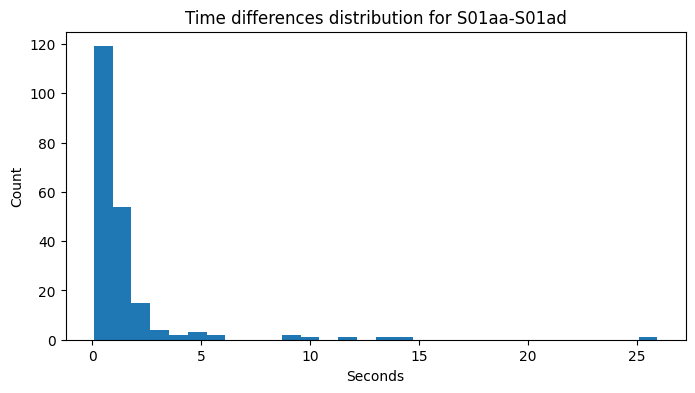

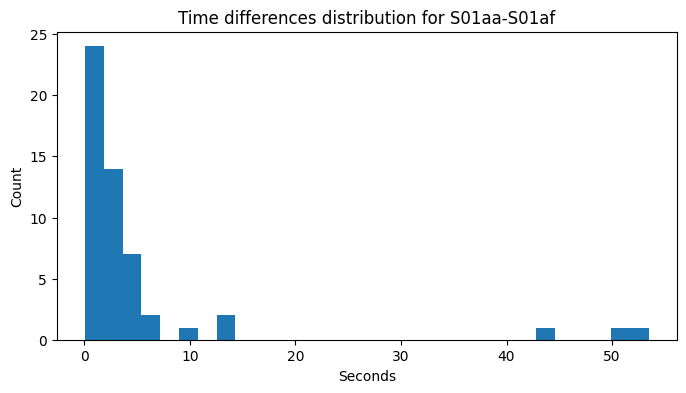

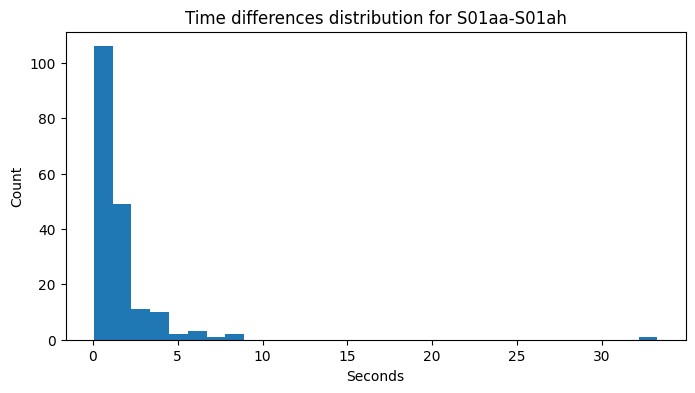

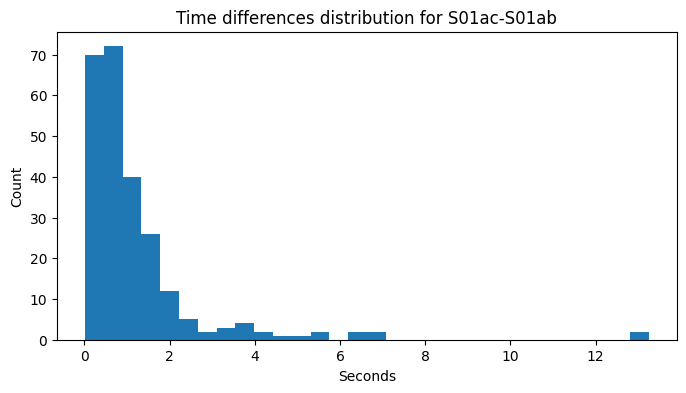

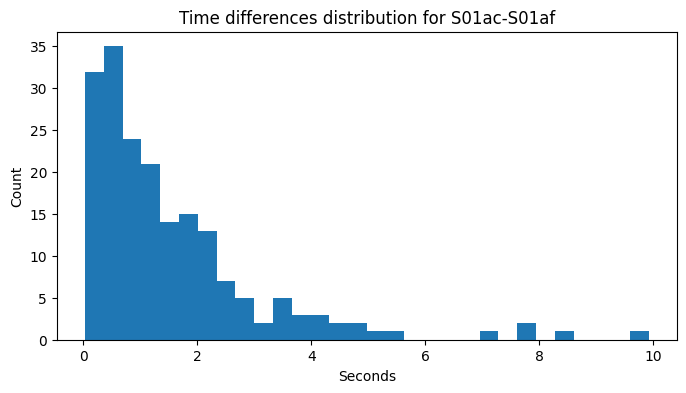

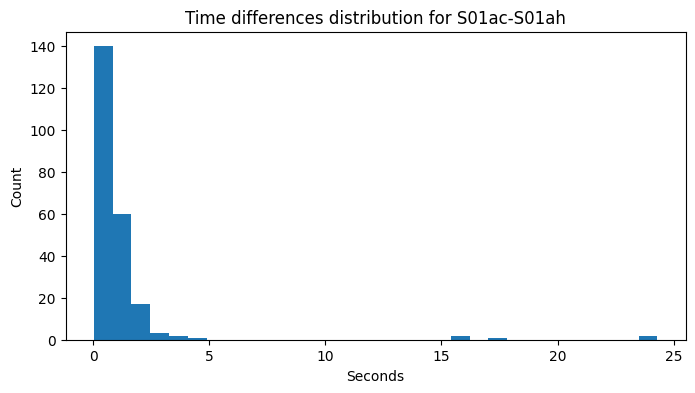

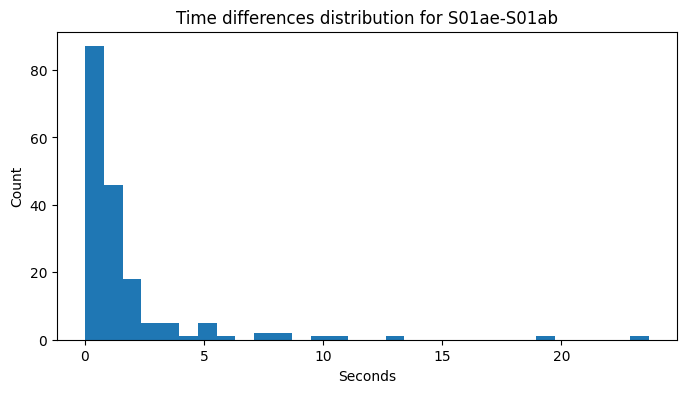

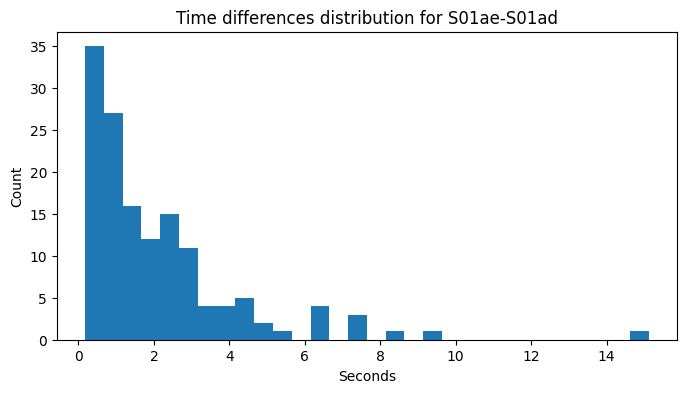

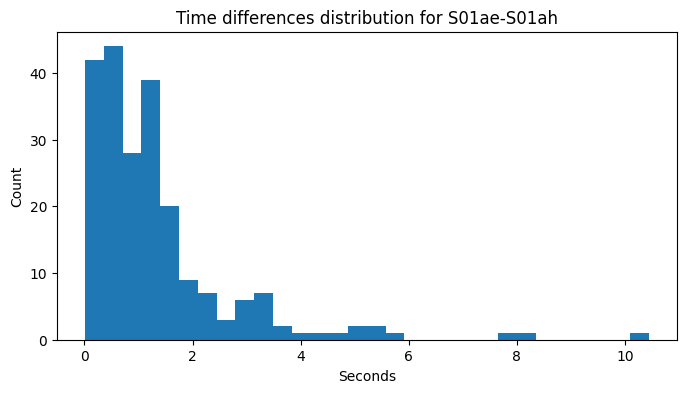

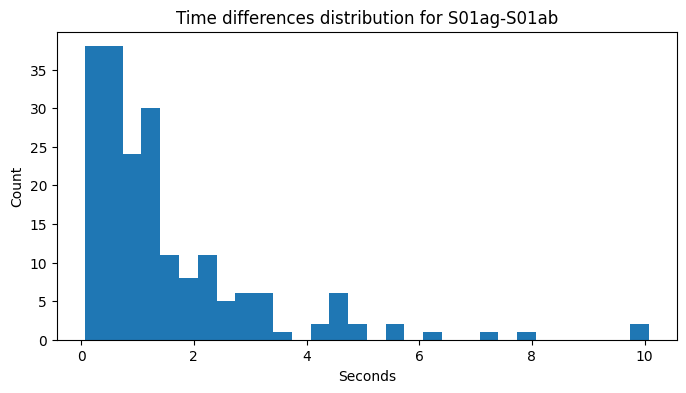

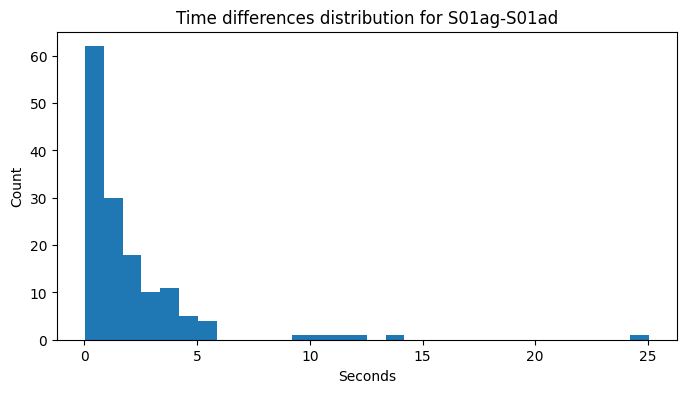

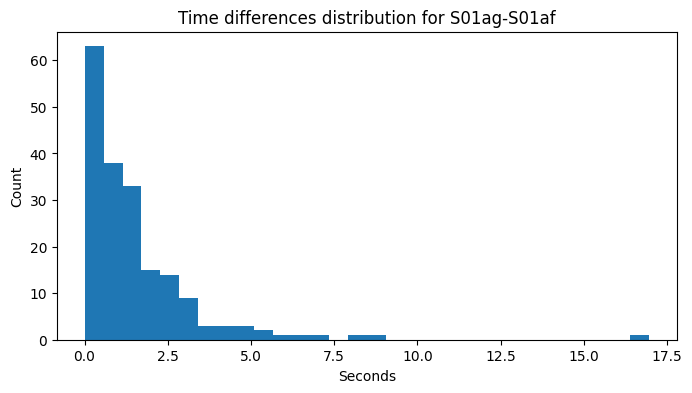

In [137]:
import matplotlib.pyplot as plt

for chute, data in distributions.items():
    plt.figure(figsize=(8,4))
    plt.hist(data, bins=30)
    plt.title(f"Time differences distribution for {chute}")
    plt.xlabel("Seconds")
    plt.ylabel("Count")
    plt.show()


In [138]:
# # Basic export (single sheet)
# window_df.to_excel('output.xlsx', index=False)

# # With full path
# window_df.to_excel(r'C:\Users\joacosta\Work\Beumer\MTN6\output.xlsx', 
#                    index=False,
#                    sheet_name='MTN6_Data')
# # With additional options
# window_df.to_excel('output.xlsx', 
#                    index=False,
#                    sheet_name='Data',   # Custom sheet name
#                    engine='openpyxl')   # Excel engine

# # Multiple sheets in one file
# with pd.ExcelWriter('output.xlsx', engine='openpyxl') as writer:
#     window_df.to_excel(writer, sheet_name='Sheet1', index=False)

In [139]:
# # Export to Excel with multiple sheets
# output_path = r'C:\Users\joacosta\Work\Beumer\MTN6\time_diff_analysis.xlsx'

# with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    
#     # Sheet 1: Summary statistics for each destination
#     summary_data = []
#     for destination, time_diffs in distributions.items():
#         if len(time_diffs) > 0:
#             summary_data.append({
#                 'Amazon_Destination': destination,
#                 'Count': len(time_diffs),
#                 'Mean (sec)': sum(time_diffs) / len(time_diffs),
#                 'Min (sec)': min(time_diffs),
#                 'Max (sec)': max(time_diffs),
#                 'Median (sec)': sorted(time_diffs)[len(time_diffs)//2]
#             })
    
#     summary_df = pd.DataFrame(summary_data)
#     summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
#     # Sheet 2: All raw data with time differences
#     df_bypass.to_excel(writer, sheet_name='Raw_Data', index=False)
    
#     # Individual sheets for each Amazon_Destination with full dataset
#     for destination in df_bypass['Amazon_Destination'].unique():
#         # Filter the full dataset for this destination
#         dest_df = df_bypass[df_bypass['Amazon_Destination'] == destination].copy()
        
#         # Clean sheet name (Excel has 31 char limit and doesn't allow special chars)
#         sheet_name = str(destination).replace('/', '_').replace('\\', '_')[:31]
        
#         dest_df.to_excel(writer, sheet_name=sheet_name, index=False)

# print(f"Excel file exported successfully to: {output_path}")
# print(f"Number of sheets created: {len(distributions) + 2}")  # +2 for Summary and Raw_Data
# print(f"Destinations: {list(distributions.keys())}")

In [140]:


# Export to Excel with multiple sheets
output_path = r'C:\Users\joacosta\Work\Beumer\MTN6\time_diff_analysis.xlsx'

with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    wb = writer.book
    
    # Sheet 1: Summary statistics for each destination
    summary_data = []
    for destination, time_diffs in distributions.items():
        if len(time_diffs) > 0:
            summary_data.append({
                'Amazon_Destination': destination,
                'Count': len(time_diffs),
                'Mean (sec)': sum(time_diffs) / len(time_diffs),
                'Min (sec)': min(time_diffs),
                'Max (sec)': max(time_diffs),
                'Median (sec)': sorted(time_diffs)[len(time_diffs)//2]
            })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
    # Sheet 2: All raw data with time differences
    df_bypass.to_excel(writer, sheet_name='Raw_Data', index=False)
    
    # Individual sheets for each Amazon_Destination with full dataset and histogram
    for destination in df_bypass['Amazon_Destination'].unique():
        # Filter the full dataset for this destination
        dest_df = df_bypass[df_bypass['Amazon_Destination'] == destination].copy()
        
        # Clean sheet name (Excel has 31 char limit and doesn't allow special chars)
        sheet_name = str(destination).replace('/', '_').replace('\\', '_')[:31]
        
        dest_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Get the worksheet for adding chart
        ws = writer.sheets[sheet_name]
        
        # Create histogram bins (every 0.28 seconds)
        time_diffs_clean = dest_df['time_diff'].dropna()
        if len(time_diffs_clean) > 0:
            min_val = time_diffs_clean.min()
            max_val = time_diffs_clean.max()
            bin_width = 0.28
            bins = []
            current_bin = 0
            while current_bin <= max_val + bin_width:
                bins.append(current_bin)
                current_bin += bin_width
            
            # Calculate histogram data
            hist_counts = pd.cut(time_diffs_clean, bins=bins, 
                                include_lowest=True).value_counts(sort=False).sort_index()
            
            # Create histogram data table in columns beyond the main data
            data_col_count = len(dest_df.columns)
            hist_start_col = data_col_count + 2
            
            # Write bin labels and counts
            ws.write(0, hist_start_col, 'Bin Start (sec)')
            ws.write(0, hist_start_col + 1, 'Count')
            
            for idx, (bin_label, count) in enumerate(hist_counts.items(), start=1):
                bin_start = bin_label.left
                ws.write(idx, hist_start_col, bin_start)
                ws.write(idx, hist_start_col + 1, count)
            
            # Create histogram chart
            histogram = wb.add_chart({'type': 'column'})
            histogram.add_series({
                'name': f'Time Difference Distribution - {destination}',
                'categories': [sheet_name, 1, hist_start_col, len(hist_counts), hist_start_col],
                'values': [sheet_name, 1, hist_start_col + 1, len(hist_counts), hist_start_col + 1],
                'gap': 2,  # Minimal gap between bars for histogram look
            })
            
            histogram.set_title({'name': f'Time Difference Histogram - {destination}'})
            histogram.set_x_axis({
                'name': 'Time Difference (seconds)',
                'min': 0,
            })
            histogram.set_y_axis({'name': 'Frequency (Count)'})
            histogram.set_legend({'position': 'none'})
            
            # Insert chart at the top right of the sheet
            ws.insert_chart(1, data_col_count + 4, histogram, {'x_scale': 1.5, 'y_scale': 1.5})

print(f"Excel file exported successfully to: {output_path}")
print(f"Number of sheets created: {len(distributions) + 2}")  # +2 for Summary and Raw_Data
print(f"Destinations: {list(distributions.keys())}")

Excel file exported successfully to: C:\Users\joacosta\Work\Beumer\MTN6\time_diff_analysis.xlsx
Number of sheets created: 14
Destinations: ['S01aa-S01ad', 'S01aa-S01af', 'S01aa-S01ah', 'S01ac-S01ab', 'S01ac-S01af', 'S01ac-S01ah', 'S01ae-S01ab', 'S01ae-S01ad', 'S01ae-S01ah', 'S01ag-S01ab', 'S01ag-S01ad', 'S01ag-S01af']
